In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import make_scorer, recall_score, f1_score
import ast      
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix   
from sklearn.model_selection import cross_val_predict 
import shap

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [2]:
df = pd.read_csv('../data/processed/df_2009-2020Total.csv')

categorical_features = [
        'SDDSRVYR','RIAGENDR', 'RIDRETH3', 'DMDBORN4', 'DMDEDUC2','RIDEXPRG', 'DMDMARTZ',
        'ALQ111', 'ALQ121', 'ALQ142','ALQ151','BPQ020','BPQ040A','BPQ050A','BPQ080','BPQ090D',
        'DIQ160','DIQ010','DBQ197','DBQ700','HIQ011','INDFMMPC','MCQ080','MCQ160B','MCQ160C','MCQ160M','MCQ300C',
        'DPQ020','DPQ030','DPQ040','DPQ060','DPQ070','PAQ605','PAQ620','PAQ635','PAQ650','PAQ665','SLQ120',
        'SMQ020','SMQ040','Diabetes_Status','Insulin_Resistance'
    ]

columns_to_drop_1 = [
    "LBXHSCRP", "SLQ120", "ALQ111", "SMD030", "SMQ040", "LBDFERSI",
    "BPQ040A", "BPQ050A", "RIDEXPRG", "SMD650", "DID040", "DBD041", "DBD030","INDFMPIR","LBXTR","BPQ090D",
    "WTSAFPRP","WTMECPRP",'WTINTPRP',
    "DIQ160","DBD900",
    "SDDSRVYR","SEQN","DIQ010","DID040",
    "Insulin_Resistance","HOMA_IR","LBDGLUSI","LBXGH"
]

df.drop(columns=columns_to_drop_1, inplace=True)

categorical_features = [col for col in categorical_features if col not in columns_to_drop_1]
numerical_features = [col for col in df.columns if col not in categorical_features]

In [3]:
print(df.shape)
# Dropping rows with missing values in specific columns
subset_cols = ['MCQ300C', 'ALQ130', 'WHD120', 'AvgSystolicBP', 
               'AvgDiastolicBP', 'BMXWAIST', 'BPQ080', 'LBDLDL', 'AvgPulseRate','WHD110','INDFMMPC']

df = df.dropna(subset=subset_cols)
df = df.dropna()
#print(df.isna().sum())
print(df.shape)

(16806, 55)
(4954, 55)


In [4]:

target = "Diabetes_Status"  

numerical_features = [col for col in numerical_features if col != target]
categorical_features = [col for col in categorical_features if col != target]


preprocessor = ColumnTransformer([
    ('num', StandardScaler(), numerical_features),
    ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
])

rf_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_jobs=-1, class_weight="balanced", random_state=42
    ))
])

X = df.drop(columns=[target]); y = df[target].astype(int)  

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

scoring = {
    'recall_macro': make_scorer(recall_score, average="macro"),
    'f1_macro': make_scorer(f1_score, average="macro"),
    'F1_cl_2': make_scorer(recall_score, labels=[2], average=None)
}

param_grid = {
    'classifier__n_estimators': [500],
    'classifier__max_depth': [500, 1000],
    'classifier__min_samples_split': [2, 5],
    'classifier__min_samples_leaf': [5, 10, 20],
    'classifier__max_features': ['sqrt'],
    'classifier__class_weight': ['balanced_subsample'],
}

grid_search = GridSearchCV(
    rf_pipeline, param_grid,
    scoring=scoring, cv=5, n_jobs=-1,
    refit=False, verbose=1
)

grid_search.fit(X_train, y_train)

results_df = pd.DataFrame(grid_search.cv_results_)

selected_columns = ['params'] + [f'mean_test_{metric}' for metric in scoring]
results_df = results_df[selected_columns]

#results_df

Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [5]:
results_df

,params,mean_test_recall_macro,mean_test_f1_macro,mean_test_F1_cl_2
0,{'classifier__class_weight': 'balanced_subsamp...,0.553385,0.559178,0.442789
1,{'classifier__class_weight': 'balanced_subsamp...,0.553385,0.559178,0.442789
2,{'classifier__class_weight': 'balanced_subsamp...,0.557983,0.547181,0.539155
3,{'classifier__class_weight': 'balanced_subsamp...,0.557983,0.547181,0.539155
4,{'classifier__class_weight': 'balanced_subsamp...,0.554599,0.524813,0.606926
5,{'classifier__class_weight': 'balanced_subsamp...,0.554599,0.524813,0.606926
6,{'classifier__class_weight': 'balanced_subsamp...,0.553385,0.559178,0.442789
7,{'classifier__class_weight': 'balanced_subsamp...,0.553385,0.559178,0.442789
8,{'classifier__class_weight': 'balanced_subsamp...,0.557983,0.547181,0.539155
9,{'classifier__class_weight': 'balanced_subsamp...,0.557983,0.547181,0.539155


In [6]:
param = 0

def RF_simple(X_train, y_train, param_grid):
    mod_RF_simple = RandomForestClassifier(**param_grid, n_jobs=-1, random_state=42)
    mod_RF_simple.fit(X_train, y_train)
    return mod_RF_simple

def plot_confusion_matrix(y_true, y_pred, title, ax, class_labels):
    cm = confusion_matrix(y_true, y_pred, labels=class_labels)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('True')
    ax.set_xticklabels(class_labels)
    ax.set_yticklabels(class_labels)

def print_rapports(y_true, y_pred, class_labels):
    fig, axes = plt.subplots(1, 1, figsize=(10, 4))
    
    # Matrice de confusion pour les données
    axes.set_title("Matrice de confusion")
    plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix', ax=axes, class_labels=class_labels)

    plt.tight_layout()
    plt.show()

    # Rapport de classification
    print("Rapport de classification :")
    print(classification_report(y_true, y_pred))

F1-score (Train CV): 0.5495
F1-score (Test): 0.5534
F1-score (Test CV): 0.5295


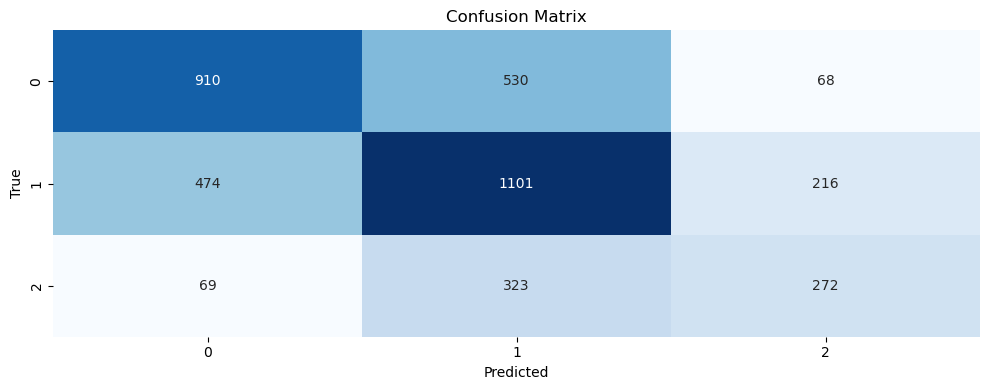

Rapport de classification :
              precision    recall  f1-score   support

           0       0.63      0.60      0.61      1508
           1       0.56      0.61      0.59      1791
           2       0.49      0.41      0.45       664

    accuracy                           0.58      3963
   macro avg       0.56      0.54      0.55      3963
weighted avg       0.57      0.58      0.57      3963



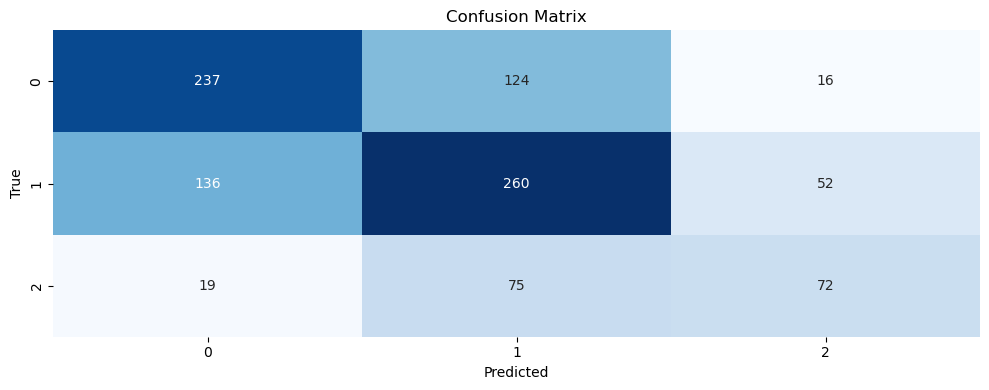

Rapport de classification :
              precision    recall  f1-score   support

           0       0.60      0.63      0.62       377
           1       0.57      0.58      0.57       448
           2       0.51      0.43      0.47       166

    accuracy                           0.57       991
   macro avg       0.56      0.55      0.55       991
weighted avg       0.57      0.57      0.57       991



In [7]:
# Sélection des hyperparamètres 
param_check = {k.replace("classifier__", ""): v for k, v in results_df['params'][param].items()}

mod_RF = RF_simple(X_train, y_train, param_check)

# Prédiction sur le train validation croisée
y_train_pred_cv = cross_val_predict(mod_RF, X_train, y_train, cv=3)

# Entraînement sur l'ensemble d'entraînement et prédiction sur letest
mod_RF.fit(X_train, y_train)
y_test_pred = mod_RF.predict(X_test)

#
y_test_pred_cv = cross_val_predict(mod_RF, X_test, y_test, cv=3)

# F1-score
f1_train_cv = f1_score(y_train, y_train_pred_cv, average="macro")
f1_test = f1_score(y_test, y_test_pred, average="macro")
f1_test_cv = f1_score(y_test, y_test_pred_cv, average="macro")

print(f"F1-score (Train CV): {f1_train_cv:.4f}")
print(f"F1-score (Test): {f1_test:.4f}")
print(f"F1-score (Test CV): {f1_test_cv:.4f}")


# Affichage des résultats
class_labels = [0, 1, 2]
print_rapports(y_train, y_train_pred_cv, class_labels)
print_rapports(y_test, y_test_pred, class_labels)

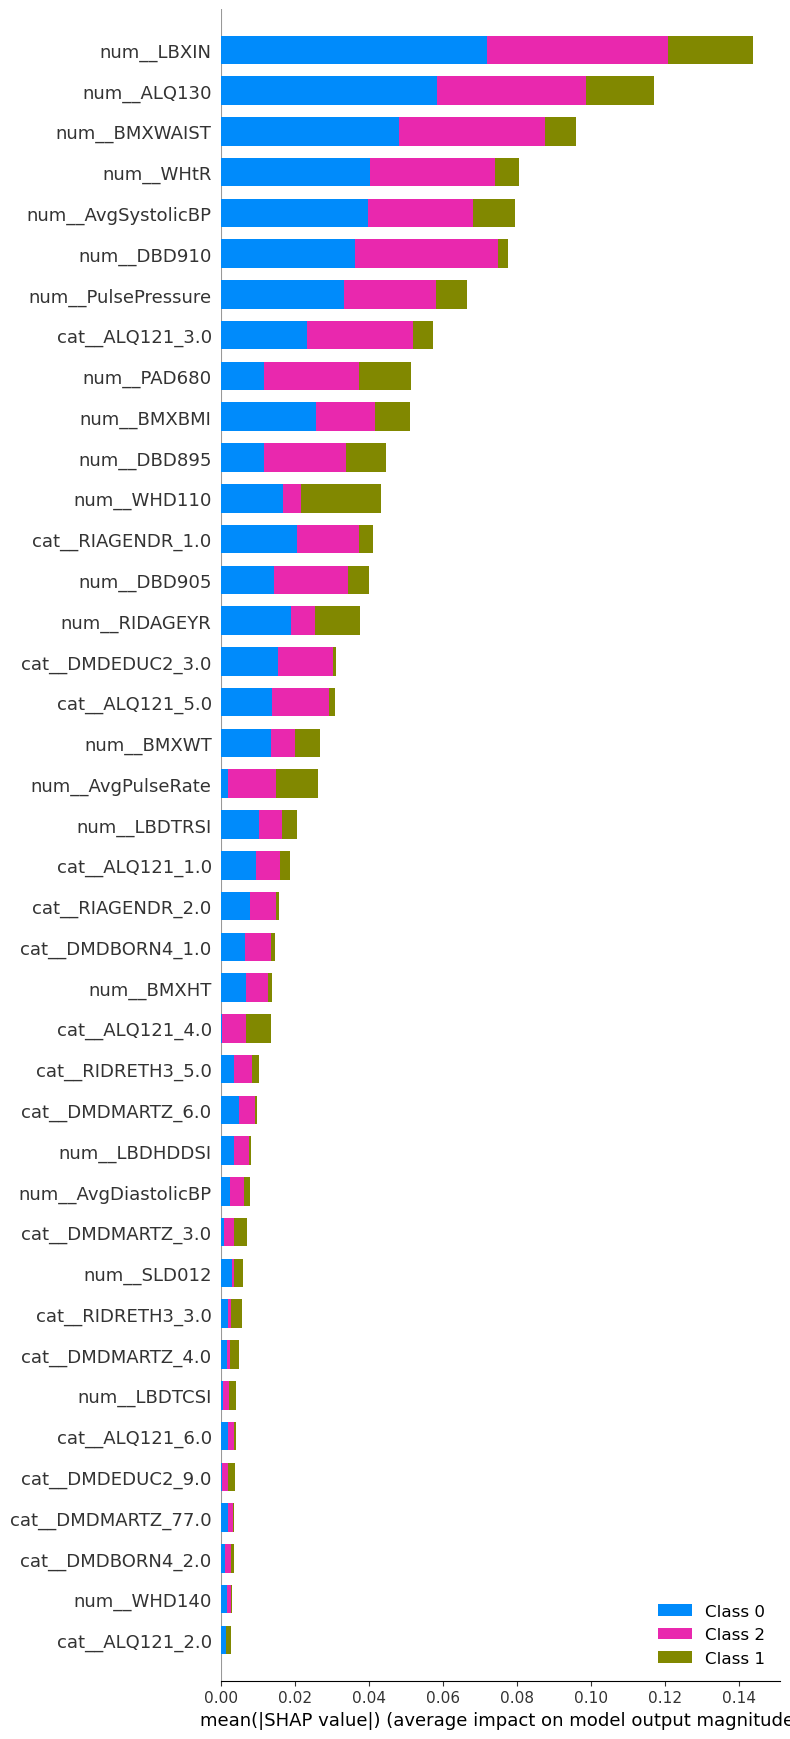

In [8]:
# Предобработка данных вручную (если без Pipeline)
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Обучение модели (без Pipeline)
#mod_RF = RandomForestClassifier(n_estimators=1000, max_depth=20, random_state=42, class_weight="balanced")
#mod_RF.fit(X_train_transformed, y_train)

# SHAP-анализ
explainer = shap.TreeExplainer(mod_RF)
shap_values = explainer.shap_values(X_test_transformed)

# Визуализация
shap.summary_plot(shap_values, X_test_transformed, feature_names=preprocessor.get_feature_names_out(), max_display=40)

In [9]:
df["DMDMARTZ"].value_counts()

1.0     3074
3.0      634
2.0      596
5.0      340
6.0      196
4.0      112
77.0       2
Name: DMDMARTZ, dtype: int64